In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in the data.
path = './datasets/titanic_train.csv'
titanic = pd.read_csv(path)
titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [3]:
# create a test set
holdout = titanic.sample(frac=.1).copy()
titanic.drop(holdout.index,inplace=True)

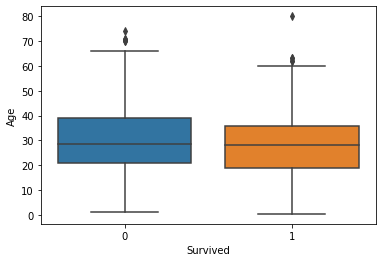

In [4]:
# age is not especially revealing
sns.boxplot('Survived','Age',data=titanic);

In [35]:
# but small children seem to be disproportionately likely to survive
titanic['Age'] = titanic['Age'].round(0)
grouped_age = titanic.groupby(['Age'])['Survived'].agg(['mean','count']).reset_index()
grouped_age[grouped_age.Age<10]

,Age,mean,count
0,0.0,1.000000,1
1,1.0,0.833333,12
2,2.0,0.300000,10
3,3.0,0.833333,6
4,4.0,0.666667,9
5,5.0,1.000000,4
6,6.0,0.666667,3
7,7.0,0.333333,3
8,8.0,0.500000,4
9,9.0,0.333333,6


In [43]:
# surival rates for embarkments do appear to be significantly different
emb = titanic.groupby(['Embarked'])['Survived'].agg(['mean','count']).reset_index()
emb.columns=['Embarked','emb_rate','count']
emb#.plot(x='Embarked',y='emb_rate',kind='barh',title='Surival Rate by Port of Embarkation');

,Embarked,emb_rate,count
0,C,0.558442,154
1,Q,0.422535,71
2,S,0.330435,575


In [7]:
# women are dramatically more likely to survive than men
sex = titanic.groupby(['Sex'])['Survived'].mean().reset_index()#.plot(kind='barh',);
sex.columns=['Sex','sex_rate']
sex

,Sex,sex_rate
0,female,0.754448
1,male,0.184261


In [8]:
# the higher the passenger class, the likelier the passenger is to survive
pclass = titanic.groupby(['Pclass'])['Survived'].mean().reset_index()
pclass.columns=['Pclass','pclass_rate']
pclass

,Pclass,pclass_rate
0,1,0.635897
1,2,0.469512
2,3,0.241535


In [9]:
# looking at the combination of passenger class and sex shows how much likelier women in the same passenger class
# were to survive than men
sex_pclass = titanic.groupby(['Pclass','Sex'])['Survived'].agg(['mean','count']).reset_index().rename(columns={
    'mean':'sex_pclass_rate'})
sex_pclass

,Pclass,Sex,sex_pclass_rate,count
0,1,female,0.965116,86
1,1,male,0.376147,109
2,2,female,0.913043,69
3,2,male,0.147368,95
4,3,female,0.523810,126
5,3,male,0.129338,317


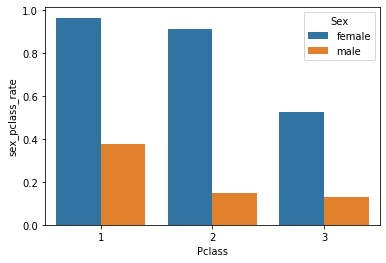

In [48]:
sns.barplot(x='Pclass',y='sex_pclass_rate',data=sex_pclass,hue='Sex');

### baseline surival

In [25]:
# we'd expect to be right 61.6% of the time just guessing every passenger died
titanic.Survived.value_counts('mean')

0    0.61596
1    0.38404
Name: Survived, dtype: float64

### with no feature engineering

In [10]:
# Fill in the missing values for age with the median age.
titanic.Age.fillna(titanic.Age.median(), inplace=True)
holdout.Age.fillna(titanic.Age.median(), inplace=True)

In [11]:
# convert sex to numeric
# set feature cols
X_train = titanic[['Embarked','Pclass','Age','Sex']].copy()
X_train['Sex']=X_train['Sex'].map(lambda x: 1 if x=='male' else 0)
# get dummies for categories
X_train = pd.get_dummies(X_train,columns=['Embarked','Pclass'])
y_train = titanic.Survived
# Fit a classification tree with max_depth=3 to visualize tree 
treeclf = DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,min_impurity_decrease=.001)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
# Create a Graphviz file.
#from sklearn.tree import export_graphviz
# Create a Graphviz file.
#export_graphviz(treeclf, out_file='./tree_titanic.dot', feature_names=X_train.columns)
# use dot -Tpng tree_titanic.dot -o tree_titanic.png to convert to png

# we see women in first and second class are overwhelmingly like to survive (149/157)
# women in third class who did not embrak from S were much more likely to survive than those who did
# male children under 10 were 50/50 to survive
# among other men, the best path to survival was being in first class and not being old

![](tree_titanic.png)

In [12]:
# select feature columns
X_test = holdout[['Embarked','Pclass','Age','Sex']].copy()
# convert sex to numeric
X_test['Sex']=X_test['Sex'].map(lambda x: 1 if x=='male' else 0)
# get dummies for categories
X_test = pd.get_dummies(X_test,columns=['Embarked','Pclass'])
y_test = holdout.Survived

In [13]:
treeclf.score(X_test, y_test)

0.7640449438202247

In [14]:
# get predictions for X test values 
preds = treeclf.predict(X_test)
# pass predictions and y test values into function
conmat = confusion_matrix(y_test, preds)
confusion = pd.DataFrame(conmat, index=['Actual: 0','Actual: 1'],
                         columns=['Pred: 0','Pred: 1'])
# roughly equal number of false positives and false negatives
confusion

,Pred: 0,Pred: 1
Actual: 0,51,4
Actual: 1,17,17


In [15]:
#comparing to logistic regression
logr = LogisticRegression(solver='liblinear')
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

0.7191011235955056

In [16]:
preds = logr.predict(X_test)
conmat = confusion_matrix(y_test, preds)
confusion = pd.DataFrame(conmat, index=['Actual: 0','Actual: 1'],
                         columns=['Pred: 0','Pred: 1'])
# applying our engineered features, we cut down on false positives by 3
confusion

,Pred: 0,Pred: 1
Actual: 0,42,13
Actual: 1,12,22


### does our logistic regression do better with engineered features?

In [17]:
# add the surival rate for each gender in each passenger class to test and train
titanic = titanic.merge(sex_pclass.drop('count',axis=1),
                    on=['Sex','Pclass'])
holdout = holdout.merge(sex_pclass.drop('count',axis=1),
                    on=['Sex','Pclass'])

In [18]:
# subset feature cols from titanic
X_train = titanic[['Embarked','sex_pclass_rate','Age']].copy()
# create age flag
X_train['u9']=X_train['Age'].map(lambda x: 1 if x<9 else 0)
# subset feature cols from X_train
X_train = X_train[['Embarked','sex_pclass_rate','u9']]
# get dummies for embarkments; drop first for linear model
X_train = pd.get_dummies(X_train,columns=['Embarked'],drop_first=True)
# get y value
y_train = titanic['Survived']

In [19]:
X_test = holdout[['Embarked','sex_pclass_rate','Age']].copy()
X_test['u9']=X_test['Age'].map(lambda x: 1 if x<9 else 0)
X_test = X_test[['Embarked','sex_pclass_rate','u9']]
X_test = pd.get_dummies(X_test,columns=['Embarked'],drop_first=True)
y_test = holdout['Survived']

In [20]:
# fit on train
logr.fit(X_train, y_train)
# score on test
logr.score(X_test, y_test)

0.7640449438202247

In [21]:
preds = logr.predict(X_test)
conmat = confusion_matrix(y_test, preds)
confusion = pd.DataFrame(conmat, index=['Actual: 0','Actual: 1'],
                         columns=['Pred: 0','Pred: 1'])
# applying our engineered features, we cut down on false positives by 3
confusion

,Pred: 0,Pred: 1
Actual: 0,51,4
Actual: 1,17,17
